# Api de Detecção de Vulnerabilidades em arquiteturas

# 1. Instalação de dependências e imports
Instalamos as bibliotecas necessárias para criar um **serviço web com FastAPI** e integrar com a **API de geração de conteúdo do Google**:  

- `fastapi` → framework web para APIs.  
- `pyngrok` → expor a API local publicamente.  
- `uvicorn` → servidor ASGI para rodar FastAPI.  
- `python-multipart` → suportar uploads de arquivos.  
- `google-generativeai` → integração com o Google Generative AI.  

Também importamos módulos auxiliares para manipulação de arquivos, imagens e configuração de CORS.  


In [ ]:
# Instalação das dependências necessárias
!pip install fastapi pyngrok uvicorn python-multipart google-generativeai

# Código principal
import os
import base64
import tempfile
import google.generativeai as genai
from fastapi import FastAPI, UploadFile, Form, File
from fastapi.responses import JSONResponse, HTMLResponse
from pathlib import Path
from fastapi.middleware.cors import CORSMiddleware
from google.colab import userdata
import nest_asyncio
from pyngrok import ngrok
import PIL.Image
import io
import json


# 2. Frontend HTML com Pico CSS e JSON

Criamos uma **interface web responsiva** usando **HTML5** e **Pico CSS**, com funcionalidades para upload de imagens, preenchimento de informações da aplicação e análise de ameaças usando o **modelo STRIDE**.

- `HTML` → estrutura da página e formulários.  
- `Pico CSS` → estilo minimalista e responsivo para a interface.  
- `Cytoscape.js` → visualização interativa do grafo de ameaças.  
- `JavaScript` → manipulação do formulário, exibição de resultados e destaque de JSON.  

A interface possui:

- **Cabeçalho estilizado** com título e descrição.  
- **Formulário dividido em cartões**:
  - Informações da aplicação (tipo, autenticação, upload de imagem).  
  - Detalhes de segurança (exposição na internet, dados sensíveis, descrição).  
- **Área de resultado**:
  - Resultado da análise em formato JSON com coloração de sintaxe.  
  - Visualização interativa do grafo STRIDE.  
  - Botões para copiar, baixar JSON e gerar relatório PDF.  

O JavaScript inclui funcionalidades como:

- **Submissão do formulário** e requisição para o endpoint `/analisar_ameacas`.  
- **Coloração de JSON** para destacar chaves, strings, números e booleanos.  
- **Inicialização do grafo Cytoscape** com layout e estilo customizados.  
- **Botões de interação**:
  - Copiar resultado.  
  - Baixar JSON.  
  - Gerar PDF (simulação via alerta).  
  - Exportar grafo como imagem para impressão.  

Essa abordagem proporciona uma experiência visual clara e interativa para análise de ameaças de segurança.


In [ ]:
# Frontend HTML com Pico CSS e JSON mais escuro
html_content = """
<!DOCTYPE html>
<html lang="pt-br">
<head>
    <meta charset="UTF-8" />
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>STRIDE - Modelo de Ameaças de Segurança</title>
    <link rel="stylesheet" href="https://unpkg.com/@picocss/pico@1.*/css/pico.min.css">
    <script src="https://cdn.jsdelivr.net/npm/cytoscape@3.24.0/dist/cytoscape.min.js"></script>
    <style>
        :root {
            --primary: #0056b3;
            --primary-hover: #004494;
            --font-size: 16px;
            --spacing: 1.5rem;
        }

        body {
            padding: 1rem;
            background-color: #f8f9fa;
            font-size: var(--font-size);
            line-height: 1.6;
        }

        .container {
            max-width: 1200px;
            margin: 0 auto;
        }

        header {
            text-align: center;
            margin-bottom: 2.5rem;
            padding: 2rem 0;
            background: linear-gradient(135deg, var(--primary) 0%, var(--primary-hover) 100%);
            color: white;
            border-radius: 12px;
            box-shadow: 0 4px 12px rgba(0,0,0,0.15);
        }

        header h1 {
            font-size: 2.5rem;
            font-weight: 800;
            margin-bottom: 0.5rem;
            text-shadow: 1px 1px 3px rgba(0,0,0,0.3);
        }

        header p {
            font-size: 1.2rem;
            font-weight: 400;
            opacity: 0.9;
            max-width: 800px;
            margin: 0 auto;
        }

        .grid {
            display: grid;
            grid-template-columns: 1fr;
            gap: 2rem;
            margin-bottom: 2rem;
        }

        @media (min-width: 768px) {
            .grid {
                grid-template-columns: 1fr 1fr;
            }
        }

        .output-area {
            background: #fff;
            border-radius: 12px;
            padding: 2rem;
            margin-top: 2.5rem;
            box-shadow: 0 4px 12px rgba(0,0,0,0.1);
            grid-column: 1 / -1;
            border-left: 5px solid var(--primary);
        }

        #cy {
            width: 100%;
            height: 550px;
            margin-top: 1.5rem;
            border: 2px solid #e9ecef;
            border-radius: 8px;
            background: #fafafa;
        }

        .hidden {
            display: none;
        }

        .card {
            background: #fff;
            border-radius: 12px;
            padding: 2rem;
            box-shadow: 0 4px 12px rgba(0,0,0,0.1);
            border-top: 4px solid var(--primary);
        }

        .card h3 {
            font-size: 1.5rem;
            font-weight: 700;
            color: var(--primary);
            margin-bottom: 1.5rem;
            padding-bottom: 0.5rem;
            border-bottom: 2px solid #e9ecef;
        }

        label {
            font-weight: 600;
            margin-bottom: 0.75rem;
            display: block;
            color: #495057;
        }

        input, select, textarea {
            font-size: 1rem;
            padding: 0.75rem;
            border: 2px solid #dee2e6;
            border-radius: 6px;
            margin-bottom: 1.25rem;
        }

        input:focus, select:focus, textarea:focus {
            border-color: var(--primary);
            box-shadow: 0 0 0 3px rgba(0, 86, 179, 0.2);
        }

        button.primary {
            background: var(--primary);
            border: none;
            padding: 1rem 2rem;
            font-size: 1.1rem;
            font-weight: 600;
            border-radius: 8px;
            transition: all 0.3s ease;
        }

        button.primary:hover {
            background: var(--primary-hover);
            transform: translateY(-2px);
            box-shadow: 0 4px 12px rgba(0,0,0,0.2);
        }

        .text-result {
            background: #f8f9fa;
            padding: 1.5rem;
            border-radius: 8px;
            margin-bottom: 2rem;
            max-height: 350px;
            overflow-y: auto;
            white-space: pre-wrap;
            font-family: 'Fira Code', 'Courier New', monospace;
            font-size: 0.95rem;
            line-height: 1.5;
            border: 1px solid #dee2e6;
            color: #2c3e50; /* Texto mais escuro */
            font-weight: 500; /* Peso de fonte maior */
        }

        /* Estilização específica para JSON */
        .text-result.json-output {
            background: #f8f9fa;
            color: #2c3e50;
            font-weight: 500;
        }

        /* Destaque para chaves JSON */
        .text-result.json-output .json-key {
            color: #0056b3;
            font-weight: 600;
        }

        /* Destaque para valores string JSON */
        .text-result.json-output .json-string {
            color: #27ae60;
        }

        /* Destaque para valores numéricos JSON */
        .text-result.json-output .json-number {
            color: #e74c3c;
        }

        /* Destaque para valores booleanos JSON */
        .text-result.json-output .json-boolean {
            color: #9b59b6;
        }

        .button-group {
            display: flex;
            gap: 0.75rem;
            margin-top: 1.5rem;
            flex-wrap: wrap;
        }

        button.secondary {
            background: #6c757d;
            border: none;
            padding: 0.75rem 1.5rem;
            font-size: 1rem;
            font-weight: 600;
            border-radius: 6px;
            transition: all 0.2s ease;
        }

        button.secondary:hover {
            background: #5a6268;
            transform: translateY(-1px);
        }

        h2 {
            font-size: 2rem;
            font-weight: 700;
            color: var(--primary);
            margin-bottom: 1.5rem;
        }

        h3 {
            font-size: 1.5rem;
            font-weight: 600;
            color: #343a40;
            margin-bottom: 1rem;
            display: flex;
            align-items: center;
        }

        .section-title {
            display: flex;
            align-items: center;
            justify-content: space-between;
            margin-bottom: 1.5rem;
        }

        .badge {
            background: var(--primary);
            color: white;
            padding: 0.25rem 0.75rem;
            border-radius: 20px;
            font-size: 0.85rem;
            font-weight: 600;
        }

        /* Adicionando uma barra de rolagem personalizada */
        .text-result::-webkit-scrollbar {
            width: 8px;
        }

        .text-result::-webkit-scrollbar-track {
            background: #f1f1f1;
            border-radius: 4px;
        }

        .text-result::-webkit-scrollbar-thumb {
            background: #c1c1c1;
            border-radius: 4px;
        }

        .text-result::-webkit-scrollbar-thumb:hover {
            background: #a8a8a8;
        }
    </style>
</head>
<body>
    <main class="container">
        <header>
            <h1>ANÁLISE DE ARQUITETURA - MODELO DE AMEAÇAS STRIDE</h1>
            <p>Faça upload do desenho de arquitetura e preencha os detalhes para gerar uma análise completa de ameaças de segurança</p>
        </header>

        <form id="analyzeForm" enctype="multipart/form-data">
            <div class="grid">
                <div class="card">
                    <h3>Informações da Aplicação</h3>

                    <label for="imagem">
                        Desenho de Arquitetura (imagem)
                        <input type="file" id="imagem" name="imagem" accept="image/*" required>
                    </label>

                    <label for="tipo_aplicacao">
                        Tipo de Aplicação
                        <input type="text" id="tipo_aplicacao" name="tipo_aplicacao" placeholder="Web app, Mobile, API, etc." required>
                    </label>

                    <label for="autenticacao">
                        Métodos de Autenticação
                        <input type="text" id="autenticacao" name="autenticacao" placeholder="JWT, OAuth, SSO, etc." required>
                    </label>
                </div>

                <div class="card">
                    <h3>Detalhes de Segurança</h3>

                    <label for="acesso_internet">
                        Exposta na Internet?
                        <select id="acesso_internet" name="acesso_internet" required>
                            <option value="">Selecione...</option>
                            <option value="Sim">Sim</option>
                            <option value="Não">Não</option>
                        </select>
                    </label>

                    <label for="dados_sensiveis">
                        Dados Sensíveis
                        <input type="text" id="dados_sensiveis" name="dados_sensiveis" placeholder="PII, dados financeiros, saúde, etc." required>
                    </label>

                    <label for="descricao_aplicacao">
                        Descrição da Aplicação
                        <textarea id="descricao_aplicacao" name="descricao_aplicacao" rows="4" placeholder="Descreva a funcionalidade principal, componentes e fluxos de dados..." required></textarea>
                    </label>
                </div>
            </div>

            <div style="text-align: center; margin-top: 2.5rem;">
                <button type="submit" class="primary">ANALISAR AMEAÇAS DE SEGURANÇA</button>
            </div>
        </form>

        <div id="output" class="output-area hidden">
            <div class="section-title">
                <h2>RESULTADO DA ANÁLISE</h2>
                <span class="badge">STRIDE</span>
            </div>

            <div class="text-result json-output" id="textResult"></div>

            <div class="section-title">
                <h3>VISUALIZAÇÃO DE AMEAÇAS</h3>
                <button id="printGraph" class="secondary" type="button">EXPORTAR GRAFO</button>
            </div>

            <div id="cy"></div>

            <div class="button-group">
                <button id="copyText" class="secondary">COPIAR RESULTADO</button>
                <button id="downloadJson" class="secondary">BAIXAR COMO JSON</button>
                <button id="downloadPdf" class="secondary">GERAR RELATÓRIO PDF</button>
            </div>
        </div>
    </main>

    <script>
        const form = document.getElementById('analyzeForm');
        const output = document.getElementById('output');
        const textResult = document.getElementById('textResult');
        const cyContainer = document.getElementById('cy');
        const copyButton = document.getElementById('copyText');
        const downloadButton = document.getElementById('downloadJson');
        const downloadPdfButton = document.getElementById('downloadPdf');

        // Função para colorir o JSON
        function syntaxHighlightJSON(json) {
            try {
                // Tenta analisar como JSON
                const obj = JSON.parse(json);
                json = JSON.stringify(obj, null, 2);

                // Aplica a coloração de sintaxe
                json = json.replace(/("(\\u[a-zA-Z0-9]{4}|\\[^u]|[^\\"])*"(\s*:)?|\b(true|false|null)\b|-?\d+(?:\.\d*)?(?:[eE][+\-]?\d+)?)/g, function (match) {
                    let cls = 'json-number';
                    if (/^"/.test(match)) {
                        if (/:$/.test(match)) {
                            cls = 'json-key';
                        } else {
                            cls = 'json-string';
                        }
                    } else if (/true|false/.test(match)) {
                        cls = 'json-boolean';
                    } else if (/null/.test(match)) {
                        cls = 'json-null';
                    }
                    return '<span class="' + cls + '">' + match + '</span>';
                });

                return json;
            } catch (e) {
                // Se não for JSON válido, retorna o texto original
                return json.replace(/</g, '&lt;').replace(/>/g, '&gt;');
            }
        }

        form.onsubmit = async (e) => {
            e.preventDefault();
            output.classList.add('hidden');
            textResult.innerHTML = '<div style="text-align: center; padding: 2rem; color: #6c757d;">Processando análise de segurança...<br><small>Isso pode levar alguns instantes</small></div>';

            const formData = new FormData(form);
            try {
                const response = await fetch('/analisar_ameacas', {
                    method: 'POST',
                    body: formData
                });
                const data = await response.json();

                // Ajuste para a resposta do Gemini
                let texto = data.response || JSON.stringify(data, null, 2);

                // Aplica a coloração de sintaxe ao JSON
                textResult.innerHTML = syntaxHighlightJSON(texto);

                // Inicializar o gráfico Cytoscape
                initCyGraph();

                output.classList.remove('hidden');

                // Scroll suave para o resultado
                output.scrollIntoView({ behavior: 'smooth' });
            } catch (err) {
                textResult.innerHTML = '<span style="color: #e74c3c;">Erro ao processar: ' + err + '</span>';
                output.classList.remove('hidden');
            }
        };

        // Função para inicializar o gráfico
        function initCyGraph() {
            const cy = cytoscape({
                container: cyContainer,
                style: [
                    {
                        selector: 'node',
                        style: {
                            'background-color': '#0056b3',
                            'label': 'data(label)',
                            'color': '#fff',
                            'text-valign': 'center',
                            'text-halign': 'center',
                            'font-size': '12px',
                            'font-weight': 'bold',
                            'width': 'label',
                            'height': 'label',
                            'padding': '12px',
                            'border-width': 2,
                            'border-color': '#fff'
                        }
                    },
                    {
                        selector: 'edge',
                        style: {
                            'width': 3,
                            'line-color': '#6c757d',
                            'target-arrow-color': '#6c757d',
                            'target-arrow-shape': 'triangle',
                            'curve-style': 'bezier',
                            'label': 'data(label)',
                            'font-size': '10px',
                            'font-weight': 'bold',
                            'text-rotation': 'autorotate',
                            'color': '#495057',
                            'text-background-color': '#fff',
                            'text-background-opacity': 1,
                            'text-background-padding': '3px'
                        }
                    }
                ],
                elements: {
                    nodes: [
                        { data: { id: 'Usuario', label: 'Usuário' } },
                        { data: { id: 'EasyAuth', label: 'Easy Auth' } },
                        { data: { id: 'AppService', label: 'App Service' } },
                        { data: { id: 'SQL', label: 'Azure SQL' } },
                        { data: { id: 'EntraID', label: 'Entra ID' } },
                        { data: { id: 'Monitor', label: 'Monitoramento' } },

                        { data: { id: 'Spoofing1', label: 'Spoofing: Token roubado' } },
                        { data: { id: 'Spoofing2', label: 'Spoofing: Conta falsa' } },
                        { data: { id: 'Tampering1', label: 'Tampering: Req. modificada' } },
                        { data: { id: 'Tampering2', label: 'Tampering: Banco alterado' } },
                        { data: { id: 'Repudiation1', label: 'Repudiation: Ação negada' } },
                        { data: { id: 'Info1', label: 'Disclosure: Vazamento' } },
                        { data: { id: 'DoS1', label: 'DoS: Sobrecarga' } },
                        { data: { id: 'Privilege1', label: 'EoP: Acesso admin' } }
                    ],
                    edges: [
                        { data: { source: 'Usuario', target: 'EasyAuth', label: 'acessa' } },
                        { data: { source: 'EasyAuth', target: 'AppService', label: 'autoriza' } },
                        { data: { source: 'AppService', target: 'SQL', label: 'consulta' } },
                        { data: { source: 'AppService', target: 'Monitor', label: 'log' } },
                        { data: { source: 'EasyAuth', target: 'EntraID', label: 'identidade' } },

                        { data: { source: 'Spoofing1', target: 'EasyAuth' } },
                        { data: { source: 'Spoofing2', target: 'AppService' } },
                        { data: { source: 'Tampering1', target: 'AppService' } },
                        { data: { source: 'Tampering2', target: 'SQL' } },
                        { data: { source: 'Repudiation1', target: 'AppService' } },
                        { data: { source: 'Info1', target: 'SQL' } },
                        { data: { source: 'DoS1', target: 'AppService' } },
                        { data: { source: 'Privilege1', target: 'AppService' } }
                    ]
                },
                layout: {
                    name: 'cose',
                    padding: 30,
                    animate: true,
                    animationDuration: 1000
                }
            });
        }

        // Adiciona funcionalidade ao botão de impressão do grafo
        const printBtn = document.getElementById('printGraph');
        if (printBtn) {
            printBtn.onclick = function() {
                const cyElement = document.getElementById('cy');
                const printWindow = window.open('', '', 'width=1000,height=800');
                printWindow.document.write('<html><head><title>Imprimir Grafo STRIDE</title>');
                printWindow.document.write('<style>body{margin:20px; font-family: Arial, sans-serif;} h1{color: #0056b3;} #cy{width:95vw;height:80vh;border:1px solid #ccc;}</style>');
                printWindow.document.write('</head><body>');
                printWindow.document.write('<h1>Visualização de Ameaças STRIDE</h1>');
                // Clona o grafo como imagem
                const cyCanvas = cyElement.querySelector('canvas');
                if (cyCanvas) {
                    const imgData = cyCanvas.toDataURL('image/png');
                    printWindow.document.write('<img src="' + imgData + '" style="width:100%;height:auto;"/>');
                } else {
                    printWindow.document.write('<div>Não foi possível capturar o grafo.</div>');
                }
                printWindow.document.write('</body></html>');
                printWindow.document.close();
                printWindow.focus();
                printWindow.print();
            };
        }

        // Funcionalidade para copiar texto
        copyButton.addEventListener('click', () => {
            const textToCopy = textResult.textContent;
            navigator.clipboard.writeText(textToCopy).then(() => {
                alert('Texto copiado para a área de transferência!');
            });
        });

        // Funcionalidade para download como JSON
        downloadButton.addEventListener('click', () => {
            const textToDownload = textResult.textContent;
            const blob = new Blob([textToDownload], { type: 'application/json' });
            const url = URL.createObjectURL(blob);
            const a = document.createElement('a');
            a.href = url;
            a.download = 'analise-ameacas-stride.json';
            document.body.appendChild(a);
            a.click();
            document.body.removeChild(a);
            URL.revokeObjectURL(url);
        });

        // Funcionalidade para download como PDF (simulação)
        downloadPdfButton.addEventListener('click', () => {
            alert('Funcionalidade de PDF em desenvolvimento. Por enquanto, use a opção de impressão do navegador.');
        });
    </script>
</body>
</html>
"""

<>:360: SyntaxWarning: invalid escape sequence '\s'
<>:360: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2349304532.py:360: SyntaxWarning: invalid escape sequence '\s'
  json = json.replace(/("(\\u[a-zA-Z0-9]{4}|\\[^u]|[^\\"])*"(\s*:)?|\b(true|false|null)\b|-?\d+(?:\.\d*)?(?:[eE][+\-]?\d+)?)/g, function (match) {


#3. Configuração do Colab, FastAPI e Integração com Gemini

Preparação do ambiente para executar uma **aplicação web de análise de ameaças STRIDE** usando **FastAPI** e **Google Gemini** no Colab.

---

# Configuração de Secrets no Google Colab

Para que a aplicação funcione corretamente, você precisa adicionar suas credenciais como **secrets** no Google Colab.  

## Passos:

1. Clique em **Ambiente de execução → Editar secrets** no Google Colab.  
2. Adicione as seguintes secrets:

   - **NGROK** → Cole o seu token do ngrok.  
     Link para obter: [https://dashboard.ngrok.com/get-started/your-authtoken](https://dashboard.ngrok.com/get-started/your-authtoken)  

   - **GEMINI_API_KEY** → Cole a chave da API do Google Gemini.  
     Link para obter: [https://aistudio.google.com/apikey](https://aistudio.google.com/apikey)  

3. Salve as alterações.

Após configurar as secrets, a aplicação poderá acessar o ngrok e a API do Google Gemini de forma segura.

---

##  Execução assíncrona e secrets

- `nest_asyncio.apply()` → permite execução assíncrona no Google Colab.  
- Obtenção das secrets `NGROK` e `GEMINI_API_KEY` com fallback para valores padrão caso não estejam configuradas.  

---

## Exposição da aplicação

- `pyngrok` → cria um túnel público para acessar a aplicação local.  
- A URL pública permite acessar a aplicação diretamente pelo navegador.

---

##  Configuração do Gemini

- `genai.configure(api_key=GEMINI_API_KEY)` → autenticação da API de geração de conteúdo.  
- Necessário para enviar prompts e receber respostas de análise de ameaças.

---

##  Configuração do FastAPI

- `FastAPI()` → inicializa a aplicação.  
- Middleware CORS → permite requisições de qualquer origem, facilitando integração com frontend.

---

## Criação do prompt de análise de ameaças STRIDE

- Função `criar_prompt_modelo_ameacas` gera o prompt detalhado para o modelo Gemini.  
- Solicita:
  - Ameaças para cada categoria STRIDE: Spoofing, Tampering, Repudiation, Information Disclosure, DoS, Elevation of Privilege.  
  - Cenários plausíveis e impactos potenciais.  
  - Sugestões de melhoria baseadas em lacunas na descrição da aplicação, como:
    - Fluxos de autenticação pouco claros.
    - Informações incompletas sobre dados sensíveis.
    - Falta de detalhes arquiteturais ou da stack utilizada.

---

## Endpoint `/analisar_ameacas`

- Recebe **imagem** e **informações da aplicação** via formulário.  
- Envia os dados para o modelo Gemini.  
- Retorna resultado em JSON com:
  - `threat_model` → lista detalhada de ameaças.
  - `improvement_suggestions` → sugestões para melhorar a análise.

---

## Endpoint `/` para frontend

- Página HTML com:
  - Formulário para upload de imagem e preenchimento de detalhes da aplicação.  
  - Visualização de resultado em JSON.  
  - Gráfico interativo de ameaças usando Cytoscape.  
  - Botões para copiar, exportar JSON ou gerar PDF.

---

## Inicialização do servidor

- `uvicorn` → inicia a aplicação FastAPI no Colab.  
- Aplicação acessível via **URL pública do ngrok**.


In [ ]:

# Aplicar nest_asyncio para permitir execução assíncrona no Colab
nest_asyncio.apply()

# Obter secrets do Google Colab
try:
    NGROK_AUTH_TOKEN = userdata.get('NGROK')
    GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')  # Nova secret para Gemini
except Exception as e:
    print(f"Erro ao carregar secrets: {e}")
    print("Certifique-se de que as secrets 'NGROK' e 'GEMINI_API_KEY' estão configuradas")
    # Define valores padrão para evitar erros
    NGROK_AUTH_TOKEN = "seu_token_ngrok_aqui"
    GEMINI_API_KEY = "sua_chave_gemini_aqui"

# Configurar ngrok para expor a aplicação
ngrok.set_auth_token(NGROK_AUTH_TOKEN)
public_url = ngrok.connect(8000).public_url
print(f"URL pública da aplicação: {public_url}")

# Configuração do Gemini
genai.configure(api_key=GEMINI_API_KEY)

# Configuração do FastAPI
app = FastAPI()
app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

def criar_prompt_modelo_ameacas(tipo_aplicacao,
                                autenticacao,
                                acesso_internet,
                                dados_sensiveis,
                                descricao_aplicacao):
    prompt = f"""Aja como um especialista em cibersegurança com mais de 20 anos de experiência
    utilizando a metodologia de modelagem de ameaças STRIDE para produzir modelos de ameaças
    abrangentes para uma ampla gama de aplicações. Sua tarefa é analisar o resumo do código,
    o conteúdo do README e a descrição da aplicação fornecidos para produzir uma lista de
    ameaças específicas para essa aplicação.

    Presta atenção na descrição da aplicação e nos detalhes técnicos fornecidos.

    Para cada uma das categorias do STRIDE (Falsificação de Identidade - Spoofing,
    Violação de Integridade - Tampering,
    Repúdio - Repudiation,
    Divulgação de Informações - Information Disclosure,
    Negação de Serviço - Denial of Service, e
    Elevação de Privilégio - Elevation of Privilege), liste múltiplas (3 ou 4) ameaças reais,
    se aplicável. Cada cenário de ameaça deve apresentar uma situação plausível em que a ameaça
    poderia ocorrer no contexto da aplicação.

    A lista de ameaças deve ser apresentada em formato de tabela,
    com as seguintes colunas:Ao fornecer o modelo de ameaças, utilize uma resposta formatada em JSON
    com as chaves "threat_model" e "improvement_suggestions". Em "threat_model", inclua um array de
    objetos com as chaves "Threat Type" (Tipo de Ameaça), "Scenario" (Cenário), e
    "Potential Impact" (Impacto Potencial).

    Ao fornecer o modelo de ameaças, utilize uma resposta formatada em JSON com as chaves
    "threat_model" and "improvement_suggestions".
    Em "threat_model", inclua um array de objetos com as chaves "Threat Type" (Tipo de Ameaça),
    "Scenario" (Cenário), e "Potential Impact" (Impacto Potencial).

    Em "improvement_suggestions", inclua um array de strings que sugerem quais informações adicionais
    poderiam ser fornecidas para tornar o modelo de ameaças mais completo e preciso na próxima iteração.
    Foque em identificar lacunas na descrição da aplicação que, se preenchidas, permitirían uma
    análise mais detalhada e precisa, como por exemplo:
    - Detalhes arquiteturais ausentes que ajudariam a identificar ameaças mais específicas
    - Fluxos de autenticação pouco claros que precisam de mais detalhes
    - Descrição incompleta dos fluxos de dados
    - Informações técnicas da stack não informadas
    - Fronteiras ou zonas de confiança do sistema não especificadas
    - Descrição incompleta do tratamento de dados sensíveis
    - Detalhes sobre
    Não forneça recomendações de segurança genéricas — foque apenas no que ajudaria a criar um
    modelo de ameaças mais eficiente.

    TIPO DE APLICAÇÃO: {tipo_aplicacao}
    MÉTODOS DE AUTENTICAÇÃO: {autenticacao}
    EXPOSTA NA INTERNET: {acesso_internet}
    DADOS SENSÍVEIS: {dados_sensiveis}
    RESUMO DE CÓDIGO, CONTEÚDO DO README E DESCRIÇÃO DA APLICAÇÃO: {descricao_aplicacao}

    Exemplo de formato esperado em JSON:

    {{
      "threat_model": [
        {{
          "Threat Type": "Spoofing",
          "Scenario": "Cenário de exemplo 1",
          "Potential Impact": "Impacto potencial de exemplo 1"
        }},
        {{
          "Threat Type": "Spoofing",
          "Scenario": "Cenário de exemplo 2",
          "Potential Impact": "Impacto potencial de exemplo 2"
        }}
        // ... mais ameaças
      ],
      "improvement_suggestions": [
        "Por favor, forneça mais detalhes sobre o fluxo de autenticação entre os componentes para permitir uma análise melhor de possíveis falhas de autenticação.",
        "Considere adicionar informações sobre como os dados sensíveis são armazenados e transmitidos para permitir uma análise mais precisa de exposição de datos.",
        // ... mais sugestões para melhorar o modelo de ameaças
      ]
    }}"""

    return prompt

@app.post("/analisar_ameacas")
async def analisar_ameacas(
    imagem: UploadFile = File(...),
    tipo_aplicacao: str = Form(...),
    autenticacao: str = Form(...),
    acesso_internet: str = Form(...),
    dados_sensiveis: str = Form(...),
    descricao_aplicacao: str = Form(...)
):
    try:
        # Criar o prompt para o modelo de ameaças
        prompt = criar_prompt_modelo_ameacas(tipo_aplicacao,
                                              autenticacao,
                                              acesso_internet,
                                              dados_sensiveis,
                                              descricao_aplicacao)

        # Salvar a imagem temporariamente
        content = await imagem.read()

        # Usar o modelo Gemini
        model = genai.GenerativeModel('gemini-1.5-flash')

        # Preparar a imagem para o Gemini
        img = PIL.Image.open(io.BytesIO(content))

        # Fazer a chamada para o Gemini
        response = model.generate_content([
            prompt,
            "Por favor, analise a imagem e o texto acima e forneça um modelo de ameaças detalhado.",
            img
        ])

        # Retornar a resposta do modelo
        return JSONResponse(content={"response": response.text}, status_code=200)

    except Exception as e:
        return JSONResponse(content={"error": str(e)}, status_code=500)



@app.get("/", response_class=HTMLResponse)
async def get_frontend():
    return HTMLResponse(content=html_content, status_code=200)

# Iniciar o servidor
if __name__ == "__main__":
    import uvicorn
    print(f"Aplicação disponível em: {public_url}")
    uvicorn.run(app, host="0.0.0.0", port=8000)

URL pública da aplicação: https://ed0ca9766e78.ngrok-free.app
Aplicação disponível em: https://ed0ca9766e78.ngrok-free.app


INFO:     Started server process [282]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO:     2804:d45:9b26:8300:f0b3:a7be:5905:aaef:0 - "GET / HTTP/1.1" 200 OK
INFO:     2804:d45:9b26:8300:f0b3:a7be:5905:aaef:0 - "GET /favicon.ico HTTP/1.1" 404 Not Found
INFO:     2804:d45:9b26:8300:f0b3:a7be:5905:aaef:0 - "GET / HTTP/1.1" 200 OK
INFO:     2804:d45:9b26:8300:f0b3:a7be:5905:aaef:0 - "POST /analisar_ameacas HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [282]


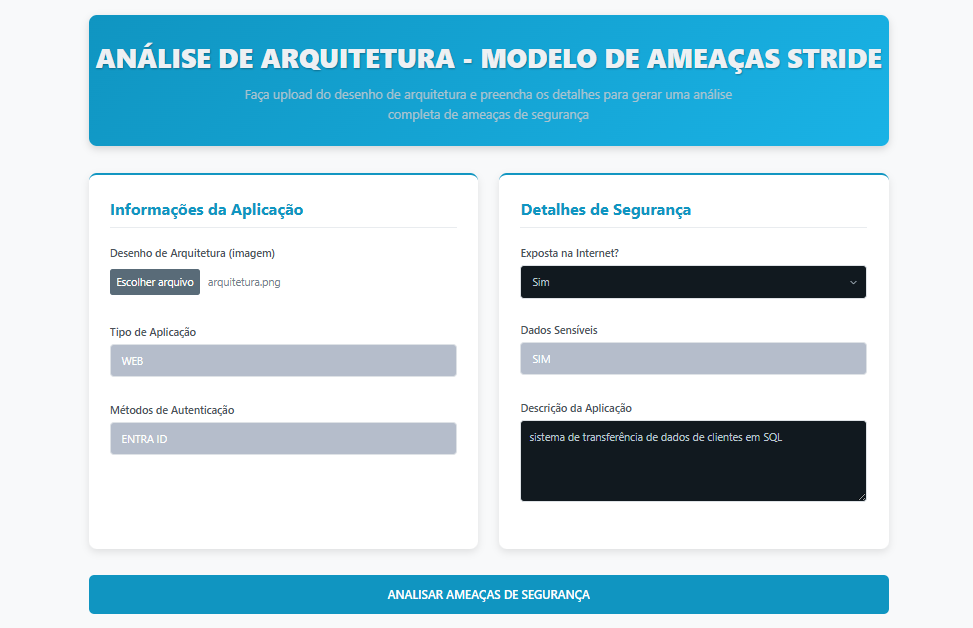